In [20]:
import pandas as pd
import numpy as np
import random
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [22]:
df = pd.read_csv('2918001_JEQUIE.csv', sep=';', dtype=str)

In [24]:
df_aux = df[['NOM_TIPO_SEGLOGR', 'NOM_SEGLOGR', 'NUM_ENDERECO']]
df_aux = df_aux.sample(n=10000, random_state=42)

In [26]:
def introduzir_erros_df_aux(df, proporcao_erros=1.0):
    df_corrupto = df.copy()
    num_erros = int(len(df) * proporcao_erros)

    for _ in range(num_erros):
        idx = random.randint(0, len(df) - 1)
        erro_tipo = random.randint(1, 5)

        if erro_tipo == 1:
            df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NOM_SEGLOGR")] = " ".join(
                str(df.iloc[idx]["NOM_SEGLOGR"]).split()[:-1])
        elif erro_tipo == 2:
            df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NOM_TIPO_SEGLOGR")] = " "
        elif erro_tipo == 3:
            valor = str(df.iloc[idx]["NOM_SEGLOGR"])
            if len(valor) > 0:
                df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NOM_SEGLOGR")] = \
                    valor[0].replace("W", "V") + valor[1:]
        elif erro_tipo == 4:
            df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NUM_ENDERECO")] = " "
        elif erro_tipo == 5:
            valor = df.iloc[idx]["NUM_ENDERECO"]
            if not pd.isnull(valor):
                df_corrupto.iloc[idx, df_corrupto.columns.get_loc("NUM_ENDERECO")] = valor

    return df_corrupto


In [27]:
df_para_erro = df_aux.sample(n=20, random_state=42)

In [28]:
df_corrupto = introduzir_erros_df_aux(df_para_erro)
df_corrupto

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO
77318,RUA,RITA DE,9
6382,RUA,DOUTOR IVAN JOSE DA SILVA,568
33028,ESTRADA,SEM DENOMINACAO,
81364,RUA,TAURINO BISPO,40
84967,,BARRO VERMELHO,0
6396,FAZENDA,ANDAIAR,
65290,,PARA JEQUIE,3
56989,,FLOR DE LIS,12
86986,,ADRIAO,23
54186,RUA,C,102


In [29]:
df_corrupto['endereco_completo_corrupto'] = df_corrupto.apply(
    lambda row: f"{row['NOM_TIPO_SEGLOGR']} {row['NOM_SEGLOGR']} {row['NUM_ENDERECO']}", axis=1
)
df_aux['endereco_completo'] = df_aux.apply(
    lambda row: f"{row['NOM_TIPO_SEGLOGR']} {row['NOM_SEGLOGR']} {row['NUM_ENDERECO']}", axis=1
)
df_corrupto['endereco_completo_corrupto']

77318                         RUA RITA DE 9
6382      RUA DOUTOR IVAN JOSE DA SILVA 568
33028             ESTRADA SEM DENOMINACAO  
81364                  RUA TAURINO BISPO 40
84967                      BARRO VERMELHO 0
6396                      FAZENDA ANDAIAR  
65290                         PARA JEQUIE 3
56989                        FLOR DE LIS 12
86986                             ADRIAO 23
54186                             RUA C 102
73593                       RUA ARNOBIO 279
38538             RUA TRAVESSA SAO JORGE 65
27570                 RUA EXPEDICIONARIO 13
28674                                    16
51110        PRACA ANTONIO FELIX DE BRITO 0
61676    RUA IDELFONSO GUEDES DE ARAUJO 652
29535                    RUA ROSA BRANCA 33
84283                  POVOADO MARCELA 1 13
31576                  RUA JOSE MIRANDA 120
42253           RUA MIGUEL GOMES DA SILVA 0
Name: endereco_completo_corrupto, dtype: object

In [30]:
# 📌 Geração de embeddings com BERT

df_novo = pd.DataFrame()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df_corrupto["embedding_nome"] = df_corrupto["endereco_completo_corrupto"].apply(lambda x: get_bert_embedding(x) if pd.notnull(x) else np.zeros(768))
df_aux["embedding_nome"] = df_aux["endereco_completo"].apply(lambda x: get_bert_embedding(x) if pd.notnull(x) else np.zeros(768))

In [9]:
# Aplicando PCA
scaler = StandardScaler()
X = np.stack(df_corrupto["embedding_nome"].values)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=16)
df_corrupto["pca_embedding"] = list(pca.fit_transform(X_scaled))

In [10]:
# Aplicando PCA
scaler = StandardScaler()
X = np.stack(df_aux["embedding_nome"].values)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=16)
df_aux["pca_embedding"] = list(pca.fit_transform(X_scaled))

In [11]:
df_corrupto.iloc[0]

NOM_TIPO_SEGLOGR                                                            RUA
NOM_SEGLOGR                                                                 BOA
NUM_ENDERECO                                                                 17
endereco_completo_corrupto                                           RUA BOA 17
embedding_nome                [-0.11782217, 0.18238942, -0.16508839, -0.4755...
pca_embedding                 [-3.6423001, -7.939495, -8.761388, -19.151857,...
Name: 86923, dtype: object

In [12]:
df_aux

,NOM_TIPO_SEGLOGR,NOM_SEGLOGR,NUM_ENDERECO,endereco_completo,embedding_nome,pca_embedding
64999,RUA,CEARA,9,RUA CEARA 9,"[-0.15727529, 0.12644473, -0.3256037, -0.37599...","[-6.230449, -11.829044, -1.6737785, -7.131944,..."
83099,AVENIDA,RIO BRANCO,533,AVENIDA RIO BRANCO 533,"[0.136259, 0.06280725, -0.061914258, -0.197512...","[-6.7513013, 12.700981, -6.5927205, -7.900155,..."
85853,ESTRADA,ITAJI JITAUNA,0,ESTRADA ITAJI JITAUNA 0,"[-0.46304744, -0.12710127, 0.12897253, -0.0792...","[12.721733, -1.0849283, -7.815792, 6.180818, 8..."
71597,RUA,EDEVALDO NETO,3,RUA EDEVALDO NETO 3,"[-0.30294582, -0.20964314, 0.17850019, -0.4032...","[-19.313547, -1.5616021, -2.2011669, -1.879494..."
8790,RUA,SEM DENOMINACAO 19,15,RUA SEM DENOMINACAO 19 15,"[-0.4115404, -0.039674934, -0.03653646, -0.183...","[-4.7629147, -2.7667525, 1.1336163, 15.414846,..."
...,...,...,...,...,...,...
47179,TRAVESSA,ITUACU,16,TRAVESSA ITUACU 16,"[-0.33619705, 0.24266624, -0.2331952, -0.02059...","[12.026458, -1.4862244, -3.3514075, 6.0881414,..."
50664,TRAVESSA,LANDUFO CARIBE,103,TRAVESSA LANDUFO CARIBE 103,"[-0.05596342, 0.12422915, -0.0404359, -0.02222...","[9.2439375, 5.732523, 0.36127198, 15.429394, 5..."
16787,BOQUEIRAO,ITAJURU,0,BOQUEIRAO ITAJURU 0,"[-0.5853739, 0.131958, -0.14857203, -0.1600257...","[-4.5866175, -6.2892933, -9.559426, 3.8054352,..."
69028,RUA,2 DE JULHO,0,RUA 2 DE JULHO 0,"[-0.46527815, -0.44437277, 0.24178842, -0.1781...","[-4.243758, -4.4441886, -3.3503985, 1.9209926,..."


In [13]:
import os
os.makedirs('data', exist_ok=True)
np.save('embedding_nome_corrupto.npy', np.array(df_corrupto['embedding_nome'].tolist()))
np.save('data/768d_uniform_data_0.npy', np.array(df_aux['embedding_nome'].tolist()))
np.save('data/768d_uniform_data_1.npy', np.array(df_aux['embedding_nome'].tolist()))
np.save('data/768d_uniform_data_2.npy', np.array(df_aux['embedding_nome'].tolist()))
np.save('data/768d_uniform_data_3.npy', np.array(df_aux['embedding_nome'].tolist()))

In [14]:
string_config = """



import errno
import os
import sys
sys.path.append("../../../")
from src.utils import FileViewer


class Config(object):

    class __Singleton(object):

        def __init__(self):

            self.data_dim = 768  # The dimension of spatial data   
            self.sigma = 100
            self.max_value = 10000  # Valor máximo
            self.T_each_dim = 90  # Número de partições por dimensão
            self.n_piecewise_models = 1024  # Número de modelos de regressão por partes
            self.eta = 0.01  # Taxa de aprendizado para otimização
            self.page_size = 78  # Tamanho da página (elementos por página)
            self.min_value = 0  # Valor mínimo
            self.lr = 1e-1  # Taxa de aprendizado
            self.tau = 50  # Número de nós em cada dimensão

            data_name = str(self.data_dim) + 'd_uniform'
            self.home_dir = os.path.join(os.path.expanduser("~"), os.path.join('workspace/LISA', data_name))
            self.models_dir = os.path.join(self.home_dir, 'models')
            self.data_dir = os.path.join(self.home_dir, 'data')
            # self.logs_dir = os.path.join(self.home_dir, logs_dir)
            FileViewer.detect_and_create_dir(self.home_dir)
            FileViewer.detect_and_create_dir(self.models_dir)
            FileViewer.detect_and_create_dir(self.data_dir)
            # FileViewer.detect_and_create_dir(self.logs_dir)


            self.query_range_path = os.path.join(self.data_dir, data_name + "_query_ranges.qr")
            self.static_data_name = data_name + "_data_0.npy"  # static data path
            self.data_to_insert_name = data_name + "_data_2.npy"  # data to insert
            self.data_to_delete_name = data_name + "_data_3.npy"  # data to delete
            self.cell_params_path = "cell_params.npy"

            # print '---------Config is initilized----------'

    instance = None

    def __new__(cls):
        if not Config.instance:
            Config.instance = Config.__Singleton()
        return Config.instance

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def __setattr__(self, name):
        return setattr(self.instance, name)

"""

In [15]:
with open('../src/utils/core/config.py', 'w', encoding='utf-8') as file:
    file.write(string_config)
print("Arquivo salvo com sucesso!")

Arquivo salvo com sucesso!


In [16]:
with open('../src/utils/core/config.py', 'r', encoding='utf-8') as file:
    content = file.read()

print(content)





import errno
import os
import sys
sys.path.append("../../../")
from src.utils import FileViewer


class Config(object):

    class __Singleton(object):

        def __init__(self):

            self.data_dim = 768  # The dimension of spatial data   
            self.sigma = 100
            self.max_value = 10000  # Valor máximo
            self.T_each_dim = 90  # Número de partições por dimensão
            self.n_piecewise_models = 1024  # Número de modelos de regressão por partes
            self.eta = 0.01  # Taxa de aprendizado para otimização
            self.page_size = 78  # Tamanho da página (elementos por página)
            self.min_value = 0  # Valor mínimo
            self.lr = 1e-1  # Taxa de aprendizado
            self.tau = 50  # Número de nós em cada dimensão

            data_name = str(self.data_dim) + 'd_uniform'
            self.home_dir = os.path.join(os.path.expanduser("~"), os.path.join('workspace/LISA', data_name))
            self.models_dir = os.path.join

In [17]:
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean

# Exemplo simples de corpus (substitua pelo seu próprio corpus de textos)
corpus = df_corrupto['endereco_completo_corrupto'].tolist()

# Treinamento do modelo Word2Vec com embedding de dimensão 16
model = Word2Vec(
    sentences=corpus,
    vector_size=16,     # <- Dimensão do vetor
    window=5,
    min_count=1,
    workers=4,
    sg=1                # usa Skip-Gram (sg=1), CBOW seria sg=0
)

corpus

print(model.wv['RUA BOA 17'])


KeyError: "Key 'RUA BOA 17' not present"

In [18]:

# Calculando a distância euclidiana entre dois vetores
vetor1 = model.wv['RUA WILTON PIMENTA 28']
vetor2 = model.wv['RUA UILTON PIMENTA 28']

distancia = euclidean(vetor1, vetor2)
print(f"Distância Euclidiana: {distancia}")

KeyError: "Key 'RUA WILTON PIMENTA 28' not present"

In [19]:
import numpy as np

def format_queries_to_qr(array_4d, delta=0.001):
    """
    Recebe um np.array (n, 4) e retorna uma string formatada com queries 4D (8 valores) no padrão .qr.
    """
    lines = []
    i = 0
    for row in array_4d:
        query_line = []
        for val in row:
            query_line.extend([val - delta, val + delta])
        query_line_str = ', '.join(f"{x:.9f}" for x in query_line)
        lines.append(f"# Query range 4D {i}\n" + query_line_str)
        i+=1
    return '\n\n'.join(lines)

def salvar_queries_em_arquivo(array_4d, caminho_arquivo="768d_uniform_query_ranges.qr", delta=0.001):
    """
    Gera e salva o conteúdo de queries 4D em um arquivo de texto.
    """
    conteudo = format_queries_to_qr(array_4d, delta)
    with open(caminho_arquivo, "w") as f:
        f.write(conteudo)
    print(f"Arquivo salvo em: {caminho_arquivo}")

# Exemplo de uso
array_exemplo = df_corrupto.iloc[0:2]['embedding_nome']

salvar_queries_em_arquivo(array_exemplo, "data/768d_uniform_query_ranges.qr", delta=0.001)


Arquivo salvo em: data/768d_uniform_query_ranges.qr


In [ ]:

# Converte em string separada por vírgulas
string_csv = ", ".join(map(str, df_corrupto.iloc[0]['embedding_nome']))
caminho_arquivo="data/768d_uniform_query_ranges.qr"
with open(caminho_arquivo, "w") as f:
    f.write(string_csv)


: 

In [ ]:
indexes_corruptos = df_corrupto.index.tolist()

df_aux.loc[indexes_corruptos].iloc[0]

NOM_TIPO_SEGLOGR                                                   RUA
NOM_SEGLOGR                                                  BOA VISTA
NUM_ENDERECO                                                        17
endereco_completo                                     RUA BOA VISTA 17
embedding_nome       [-0.3521758, 0.01850103, -0.092250556, -0.3955...
pca_embedding        [-7.5481973, -5.713695, 4.6525145, -2.1617775,...
Name: 86923, dtype: object

In [ ]:
df_corrupto.iloc[0]

NOM_TIPO_SEGLOGR                                                            RUA
NOM_SEGLOGR                                                                 BOA
NUM_ENDERECO                                                                 17
endereco_completo_corrupto                                           RUA BOA 17
embedding_nome                [-0.11782217, 0.18238942, -0.16508839, -0.4755...
pca_embedding                 [-3.6423001, -7.939495, -8.761388, -19.151857,...
Name: 86923, dtype: object

In [ ]:
from scipy.spatial.distance import euclidean

# Calculando a distância euclidiana entre embedding
vetor1 = df_aux.loc[indexes_corruptos].iloc[0]['embedding_nome']
vetor2 = df_corrupto.iloc[0]['embedding_nome']

distancia = euclidean(vetor1, vetor2)
print(f"Distância Euclidiana: {distancia}")

Distância Euclidiana: 4.867742538452148


In [ ]:
# Calculando a distância euclidiana entre PCA
vetor1 = df_aux.loc[indexes_corruptos].iloc[0]['pca_embedding']
vetor2 = df_corrupto.iloc[0]['pca_embedding']

distancia = euclidean(vetor1, vetor2)
print(f"Distância Euclidiana: {distancia}")

Distância Euclidiana: 30.883617401123047


[[-7.548197269439697, -5.713693618774414, 4.652488708496094, -2.1618001461029053], [9.454977989196777, 8.308487892150879, -4.086009502410889, 5.82037878036499], [14.421100616455078, 8.52990436553955, -4.366933822631836, 4.40529203414917], [-7.7414631843566895, 1.0974012613296509, 7.7135210037231445, -4.784732341766357], [-8.880797386169434, -4.906796932220459, 2.6181957721710205, -7.779216766357422], [11.09166431427002, -4.3435187339782715, -1.2929651737213135, -0.9428582191467285], [-13.596209526062012, -1.6789872646331787, 7.2806196212768555, -1.3490477800369263], [-16.159931182861328, -0.6743928790092468, 5.1060075759887695, -1.259033203125], [7.708611488342285, 8.409462928771973, 9.158751487731934, -0.7523069977760315], [9.122167587280273, 17.857961654663086, -1.4833496809005737, -3.683770179748535], [12.103279113769531, 3.4512016773223877, -9.772218704223633, 5.083927154541016], [-12.693948745727539, 2.5960326194763184, -12.982247352600098, 2.6207900047302246], [-3.227595806121826

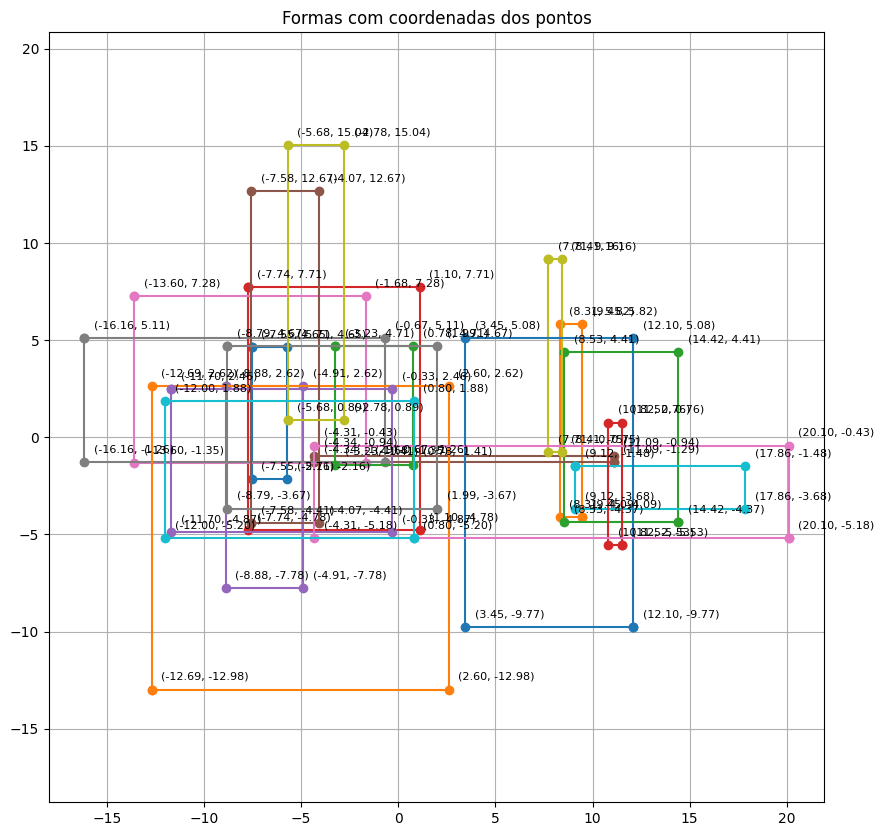

In [ ]:

import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = df_aux.loc[indexes_corruptos]['pca_embedding'].apply(lambda x: list(map(float, x))).tolist()

print(arrays)

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Valor {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
# plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()



[[-3.6426024436950684, -7.935771942138672, -8.778580665588379, -19.14615821838379], [9.901169776916504, -9.891592025756836, 4.952213764190674, 8.658012390136719], [18.370946884155273, -14.280890464782715, -7.509119033813477, 15.058880805969238], [-10.314238548278809, -2.928950309753418, 2.317631244659424, -3.309464454650879], [-5.022021770477295, -5.1827898025512695, -9.085738182067871, -9.295870780944824], [10.737279891967773, 0.7887921929359436, -5.847527980804443, 0.5642131567001343], [-15.756607055664062, 13.104763984680176, -11.284555435180664, 9.61710262298584], [-17.95696258544922, 13.2755765914917, -1.0038561820983887, 10.911468505859375], [19.729854583740234, 10.566657066345215, -14.295116424560547, 3.678009510040283], [6.673895835876465, 0.7386903166770935, 18.92637825012207, 5.374874114990234], [14.58012866973877, -4.326201438903809, 6.521198272705078, 0.1656855046749115], [-12.233617782592773, -10.357786178588867, 3.709303379058838, 1.7752958536148071], [-5.97657585144043, 

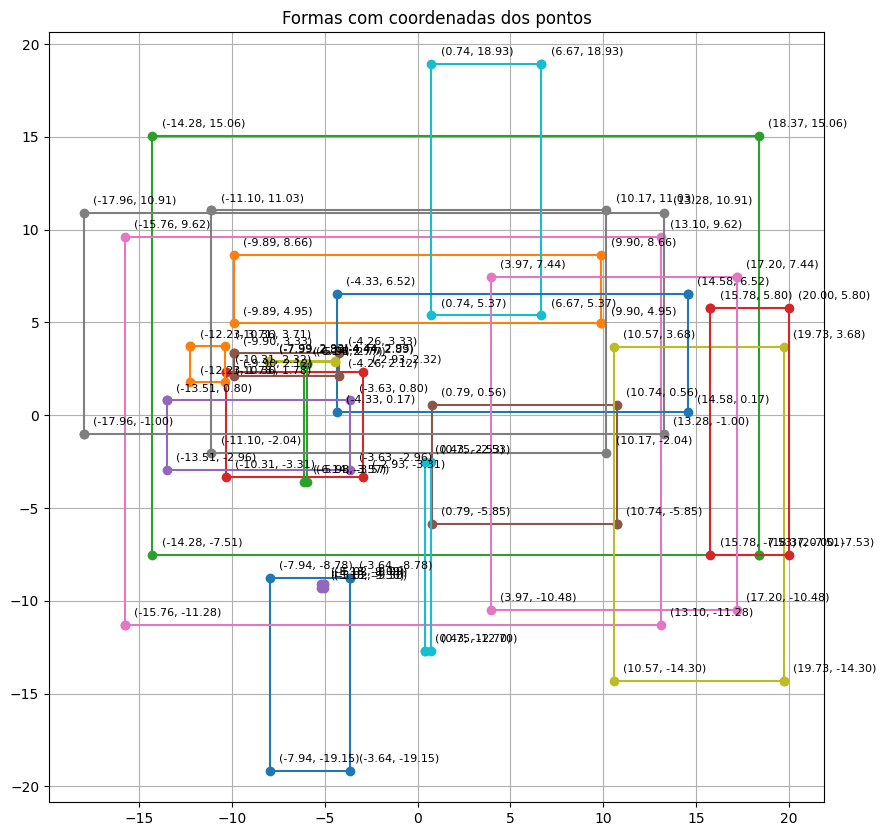

In [ ]:

import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = df_corrupto['pca_embedding'].apply(lambda x: list(map(float, x))).tolist()

print(arrays)

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Valor {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
# plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()



In [ ]:
dict_ = {
    'sigma': [],
    'T_each_dim': [],
    'n_picewise_models': [],
    'page_size': [],
    'tau': [],
}